# This model is developed based on the three month recent data from 202008 to 202010

In [39]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle

import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')
from common_functions import psi
from common_functions import ks
from common_functions import data_vars

import matplotlib.pyplot as plt

%matplotlib inline
import boto3

In [40]:
#old s3_source_path='s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202009/'
# YYYYMM = '202012'
bucket_name = 'mf-ml-ds'
# s3_source = 's3://'+ bucket_name +'/propensity_to_fund/model_monitor/val_'
# s3_source_path  = s3_source + YYYYMM
# s3_score_target  = 'propensity_to_fund/model_monitor/val_' + YYYYMM +'/'
# # pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

# psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'propensity_to_pay/final_model/'

s3 = boto3.resource('s3')

In [41]:
def upload_model(model, model_name):
    with open(model_name, 'wb') as f:
        cpickle.dump(model, f)
    s3.meta.client.upload_file(model_name, bucket_name, model_path + model_name)

In [42]:
#read in the csv model development data
#read in the csv model development data
df1=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202008/pot90.csv')
df2=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202009/pot90.csv')
df3=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202010/pot90.csv')
df=pd.concat([df1,df2, df3],ignore_index=True)

In [43]:
df=df.drop(['FFC_Source_Input_2','Dataforperiod','segment','state','roll', 'NextMonth_DQ', 'current_DQ','custom_score'], axis=1)


In [44]:
df.shape

(53889, 610)

In [45]:
ptable = pd.DataFrame()
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df.loc[df[col] <= percentiles[0], col] = percentiles[0]
    df.loc[df[col] >= percentiles[1], col] = percentiles[1]
    ptable[col]=percentiles

In [46]:
# impute all the missing value with 0
df=df.fillna(0)

In [47]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df.drop(['badflag'], axis='columns'), df.badflag, test_size=0.3)

In [48]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
# rf=RandomForestClassifier(n_estimators=300, min_samples_leaf=5)
XGB=XGBClassifier(n_estimators=300, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)

In [49]:
sel_ = SelectFromModel(XGB,max_features=50)
sel_.fit(X_train, y_train)
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
# print('features with coefficients shrank to zero: {}'.format(
#       np.sum(sel_.estimator_.coef_ == 0)))


total features: 609
selected features: 50


In [50]:
list(selected_feat)

['RefreshFicoScore',
 'MOBVintageThread',
 'yrs_on_job_dbl',
 'number_of_payments',
 '__of_days_until_pmt_date',
 'NumberOfCars',
 'MaxCarYear',
 'Times29_6mo',
 'Times30_6mo',
 'Times60_6mo',
 'Times90_6mo',
 'Times29_9mo',
 'Times30_9mo',
 'Times90_9mo',
 'Times29_12mo',
 'Times90_12mo',
 'Times29_Ever',
 'Times30_Ever',
 'Times60_Ever',
 'Times90_Ever',
 'ADA_3480',
 'ADA_3239',
 'ADA_3439',
 'ADA_3837',
 'ADA_3939',
 'ADA_3727',
 'ADA_3268',
 'ADA_3471',
 'ADA_3476',
 'ADA_3535',
 'ADA_3759',
 'ADA_3802',
 'ADA_3804',
 'ADA_3865',
 'ADA_3870',
 'ADA_3872',
 'ADA_3902',
 'ADA_3164',
 'ADA_3273',
 'ADA_3323',
 'ADA_3410',
 'ADA_3540',
 'ADA_3761',
 'ADA_3827',
 'ADA_3012',
 'ADA_3013',
 'ADA_3914',
 'ADA_3963',
 'upb_ratio',
 'state_risk']

In [51]:
X_train2=X_train[selected_feat]
X_test2=X_test[selected_feat]


In [52]:
#check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train2)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const                       78.898373
RefreshFicoScore             3.862012
MOBVintageThread             1.538565
yrs_on_job_dbl               1.067855
number_of_payments           3.857304
__of_days_until_pmt_date     1.818034
NumberOfCars                 5.845723
MaxCarYear                   5.842042
Times29_6mo                  3.757476
Times30_6mo                  3.368895
Times60_6mo                  2.851365
Times90_6mo                 10.472403
Times29_9mo                 12.595386
Times30_9mo                  5.591159
Times90_9mo                 24.962189
Times29_12mo                11.915976
Times90_12mo                22.178284
Times29_Ever                 4.274879
Times30_Ever                 4.790835
Times60_Ever                 3.997670
Times90_Ever                 9.551085
ADA_3480                     3.453032
ADA_3239                     1.483229
ADA_3439                     1.880340
ADA_3837                     1.980684
ADA_3939                     2.603073
ADA_3727    

In [53]:


X_train3=calculate_vif_(X_train2, thresh=10.0)

dropping 'Times90_9mo' at index: 13
dropping 'ADA_3870' at index: 33
dropping 'RefreshFicoScore' at index: 0
dropping 'Times29_9mo' at index: 10
dropping 'Times90_12mo' at index: 12
dropping 'Times30_9mo' at index: 10
dropping 'Times60_6mo' at index: 8
dropping 'ADA_3902' at index: 29
dropping 'ADA_3268' at index: 20
dropping 'Times90_Ever' at index: 13
dropping 'ADA_3480' at index: 13
dropping 'Times29_12mo' at index: 9
dropping '__of_days_until_pmt_date' at index: 3
Remaining variables:
Index(['MOBVintageThread', 'yrs_on_job_dbl', 'number_of_payments',
       'NumberOfCars', 'MaxCarYear', 'Times29_6mo', 'Times30_6mo',
       'Times90_6mo', 'Times29_Ever', 'Times30_Ever', 'Times60_Ever',
       'ADA_3239', 'ADA_3439', 'ADA_3837', 'ADA_3939', 'ADA_3727', 'ADA_3471',
       'ADA_3476', 'ADA_3535', 'ADA_3759', 'ADA_3802', 'ADA_3804', 'ADA_3865',
       'ADA_3872', 'ADA_3164', 'ADA_3273', 'ADA_3323', 'ADA_3410', 'ADA_3540',
       'ADA_3761', 'ADA_3827', 'ADA_3012', 'ADA_3013', 'ADA_3914'

In [54]:
X=add_constant(X_train3)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const                 48.449189
MOBVintageThread       1.524506
yrs_on_job_dbl         1.065078
number_of_payments     3.563619
NumberOfCars           5.832095
MaxCarYear             5.832259
Times29_6mo            1.526605
Times30_6mo            1.678963
Times90_6mo            1.227773
Times29_Ever           2.201875
Times30_Ever           2.832037
Times60_Ever           1.686731
ADA_3239               1.469582
ADA_3439               1.511531
ADA_3837               1.873841
ADA_3939               2.534440
ADA_3727               1.380396
ADA_3471               2.386750
ADA_3476               2.121869
ADA_3535               3.485059
ADA_3759               4.717682
ADA_3802               1.257089
ADA_3804               1.565465
ADA_3865               3.056910
ADA_3872               4.594528
ADA_3164               1.300271
ADA_3273               1.809161
ADA_3323               1.381867
ADA_3410               1.660895
ADA_3540               3.638172
ADA_3761               4.961173
ADA_3827

In [55]:
X_test3=X_test[X_train3.columns]


In [56]:
#refit the rf model
XGB.fit(X_train3, y_train)
XGB.score(X_test3, y_test)

0.8508690542463042

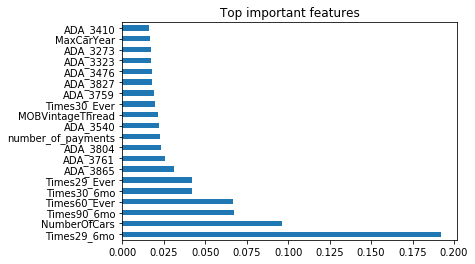

In [57]:
#rank order the variable importance
feat_importances=pd.Series(XGB.feature_importances_, index=X_train3.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [58]:
df_feat=pd.DataFrame(data=feat_importances.nlargest(50))
df_feat.to_excel('feat_importance_xgb_v2.xlsx')

In [59]:
#output the probability of being bad;
# train_pred=rf.predict_proba(X_train2)[:,1]
test_pred=XGB.predict_proba(X_test3)[:, 1]

In [60]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test3.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')

        min_score  max_score  events  nonevents   total event_rate  \
Decile                                                               
1        0.964395   0.997674  1579.0       38.0  1617.0     97.65%   
2        0.947887   0.964388  1560.0       57.0  1617.0     96.47%   
3        0.930794   0.947884  1530.0       86.0  1616.0     94.68%   
4        0.913671   0.930783  1490.0      127.0  1617.0     92.15%   
5        0.894224   0.913661  1456.0      160.0  1616.0     90.10%   
6        0.869821   0.894223  1443.0      174.0  1617.0     89.24%   
7        0.834495   0.869816  1381.0      236.0  1617.0     85.41%   
8        0.772368   0.834463  1287.0      329.0  1616.0     79.64%   
9        0.642591   0.772188  1089.0      528.0  1617.0     67.35%   
10       0.117192   0.642562   843.0      774.0  1617.0     52.13%   

       nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
Decile                                                                        
1

In [61]:
ks_test.to_excel('pot90_xgb_ks_v2.xlsx')

# !aws s3 cp pot90_xgb_ks_v2.xlsx s3://mf-ml-ds/propensity_to_pay/output/

In [62]:
#establish baseline for PSI check 
y_test_hat_df.reset_index(drop=True, inplace=True)
y_test_hat_df.to_excel('pot90baseline_xgb_v2.xlsx', index=False)

In [63]:
ptable.to_csv('../model_monitor/pot90_capfloor.csv', index=False)

In [64]:
#apply scorecard to oot dataset;
df_oot=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/pot90.csv')
df_oot.head()

,FFC_Source_Input_2,RefreshFicoScore,Loan_Type,Original_Balance,Original_PI_Constant,Original_Term,lnface,LNAPRO,UPB,number_of_prior_loans,MOBVintageUnthread,MOBVintageThread,credit_score_pm,TOTAL_INCOME,DISPOSABLE_INCOME,DEBT_RATIO_DBL,yrs_on_job_dbl,BNI,AGE,day_passed_from_app_to_open3,number_of_payments,__of_days_until_pmt_date,current_DQ,NextMonth_DQ,Dataforperiod,custom_score,RBO,Cure,Def,FICO_migration,NumberOfCars,MaxCarValue,MaxCarYear,maxCarMile,SumCarValue,MinCarYear,MincarMile,Times29_6mo,Times30_6mo,Times60_6mo,Times90_6mo,Times29_9mo,Times30_9mo,Times60_9mo,Times90_9mo,Times29_12mo,Times30_12mo,Times60_12mo,Times90_12mo,Times29_Ever,Times30_Ever,Times60_Ever,Times90_Ever,ADA_3215,ADA_3236,ADA_3368,ADA_3480,ADA_3863,ADA_3894,ADA_3224,ADA_3336,ADA_3842,ADA_3101,ADA_3117,ADA_3143,ADA_3123,ADA_3138,ADA_3160,ADA_3203,ADA_3536,ADA_3547,ADA_3558,ADA_3569,ADA_3579,ADA_3593,ADA_3609,ADA_3725,ADA_3857,ADA_3102,ADA_3113,ADA_3124,ADA_3139,ADA_3150,ADA_3161,ADA_3183,ADA_3204,ADA_3217,ADA_3228,ADA_3239,ADA_3270,ADA_3290,ADA_3309,ADA_3320,ADA_3330,ADA_3340,ADA_3350,ADA_3356,ADA_3362,ADA_3369,ADA_3370,ADA_3380,ADA_3389,ADA_3398,ADA_3407,ADA_3417,ADA_3428,ADA_3439,ADA_3450,ADA_3537,ADA_3548,ADA_3559,ADA_3570,ADA_3583,ADA_3594,ADA_3605,ADA_3616,ADA_3627,ADA_3726,ADA_3748,ADA_3753,ADA_3756,ADA_3760,ADA_3825,ADA_3833,ADA_3837,ADA_3847,ADA_3854,ADA_3860,ADA_3866,ADA_3873,ADA_3874,ADA_3875,ADA_3889,ADA_3897,ADA_3898,ADA_3899,ADA_3900,ADA_3920,ADA_3921,ADA_3922,ADA_3936,ADA_3939,ADA_3944,ADA_3945,ADA_3946,ADA_3953,ADA_3954,ADA_3955,ADA_3966,ADA_3973,ADA_3974,ADA_3975,ADA_3976,ADA_3977,ADA_3984,ADA_3989,ADA_3140,ADA_3162,ADA_3184,ADA_3838,ADA_3848,ADA_3104,ADA_3126,ADA_3141,ADA_3152,ADA_3163,ADA_3185,ADA_3205,ADA_3219,ADA_3272,ADA_3292,ADA_3311,ADA_3322,ADA_3332,ADA_3351,ADA_3357,ADA_3363,ADA_3371,ADA_3382,ADA_3391,ADA_3400,ADA_3409,ADA_3419,ADA_3430,ADA_3441,ADA_3452,ADA_3539,ADA_3550,ADA_3561,ADA_3572,ADA_3585,ADA_3596,ADA_3607,ADA_3618,ADA_3629,ADA_3727,ADA_3749,ADA_3826,ADA_3830,ADA_3834,ADA_3839,ADA_3849,ADA_3855,ADA_3867,ADA_3876,ADA_3877,ADA_3878,ADA_3890,ADA_3923,ADA_3924,ADA_3925,ADA_3956,ADA_3957,ADA_3958,ADA_3985,ADA_3990,ADA_3100,ADA_3111,ADA_3122,ADA_3133,ADA_3135,ADA_3137,ADA_3148,ADA_3159,ADA_3181,ADA_3192,ADA_3237,ADA_3268,ADA_3288,ADA_3307,ADA_3318,ADA_3329,ADA_3338,ADA_3349,ADA_3355,ADA_3361,ADA_3367,ADA_3379,ADA_3388,ADA_3397,ADA_3406,ADA_3415,ADA_3426,ADA_3437,ADA_3448,ADA_3471,ADA_3472,ADA_3473,ADA_3474,ADA_3475,ADA_3476,ADA_3477,ADA_3478,ADA_3479,ADA_3535,ADA_3546,ADA_3557,ADA_3568,ADA_3581,ADA_3592,ADA_3603,ADA_3614,ADA_3625,ADA_3743,ADA_3746,ADA_3747,ADA_3752,ADA_3755,ADA_3759,ADA_3794,ADA_3795,ADA_3796,ADA_3797,ADA_3798,ADA_3799,ADA_3800,ADA_3801,ADA_3802,ADA_3803,ADA_3804,ADA_3805,ADA_3806,ADA_3807,ADA_3812,ADA_3813,ADA_3814,ADA_3815,ADA_3832,ADA_3843,ADA_3844,ADA_3846,ADA_3864,ADA_3865,ADA_3870,ADA_3871,ADA_3872,ADA_3888,ADA_3895,ADA_3896,ADA_3902,ADA_3903,ADA_3904,ADA_3905,ADA_3907,ADA_3908,ADA_3909,ADA_3911,ADA_3912,ADA_3913,ADA_3917,ADA_3918,ADA_3919,ADA_3935,ADA_3938,ADA_3941,ADA_3942,ADA_3943,ADA_3950,ADA_3951,ADA_3952,ADA_3965,ADA_3968,ADA_3969,ADA_3970,ADA_3971,ADA_3972,ADA_3983,ADA_3988,ADA_3105,ADA_3116,ADA_3127,ADA_3136,ADA_3142,ADA_3153,ADA_3164,ADA_3193,ADA_3206,ADA_3231,ADA_3242,ADA_3273,ADA_3293,ADA_3312,ADA_3323,ADA_3333,ADA_3352,ADA_3358,ADA_3364,ADA_3372,ADA_3383,ADA_3392,ADA_3401,ADA_3410,ADA_3420,ADA_3431,ADA_3442,ADA_3453,ADA_3540,ADA_3551,ADA_3562,ADA_3573,ADA_3586,ADA_3597,ADA_3608,ADA_3619,ADA_3630,ADA_3728,ADA_3750,ADA_3757,ADA_3761,ADA_3827,ADA_3835,ADA_3840,ADA_3858,ADA_3868,ADA_3879,ADA_3880,ADA_3881,ADA_3891,ADA_3926,ADA_3927,ADA_3928,ADA_3959,ADA_3960,ADA_3961,ADA_3986,ADA_3991,ADA_3000,ADA_3001,ADA_3002,ADA_3008,ADA_3009,ADA_3010,ADA_3011,ADA_3012,ADA_3013,ADA_3014,ADA_3015,ADA_3016,ADA_3017,ADA_3018,ADA_3019,ADA_3020,ADA_3021,ADA_3022,ADA_3023,ADA_3024,ADA_3025,ADA_3026,ADA_3027,ADA_3028,ADA_3029,ADA_3030,ADA_3031,ADA_3993,ADA_3994,ADA_3995,ADA_3165,ADA_3177,ADA_3195,ADA_3207,ADA_

In [65]:
y_oot=df_oot.loc[: ,'badflag']
X_oot=df_oot.loc[: , df_oot.columns!='badflag']


In [66]:
X_oot2=X_oot[X_train3.columns]

In [67]:
for col in X_oot2.columns:

    p1 = ptable[col].min()
    p99= ptable[col].max()
    X_oot2.loc[X_oot2[col] <= p1, col] = p1
    X_oot2.loc[X_oot2[col] >= p99, col] = p99

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In [68]:
X_oot2=X_oot2.fillna(0)


In [69]:

oot_pred=XGB.predict_proba(X_oot2)[:, 1]


In [70]:
#merge only the validation dataset
y_oot_hat=oot_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_oot_hat_df=pd.DataFrame(data=y_oot_hat, columns=['Y_hats'], index=X_oot2.index.copy())

df_out=pd.merge(y_oot, y_oot_hat_df, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_out, target='badflag', prob='Y_hats')

        min_score  max_score  events  nonevents  total event_rate  \
Decile                                                              
1        0.962236   0.994906    1694         38   1732     97.81%   
2        0.944829   0.962232    1667         65   1732     96.25%   
3        0.927972   0.944813    1657         75   1732     95.67%   
4        0.910917   0.927963    1644         87   1731     94.97%   
5        0.891850   0.910909    1591        141   1732     91.86%   
6        0.868226   0.891837    1547        185   1732     89.32%   
7        0.835838   0.868212    1485        246   1731     85.79%   
8        0.776547   0.835825    1403        329   1732     81.00%   
9        0.648655   0.776502    1265        467   1732     73.04%   
10       0.070268   0.648457     894        838   1732     51.62%   

       nonevent_rate % events % nonevents % cum_events % cum_nonevents    KS  
Decile                                                                        
1            

In [72]:
#export the KS table to an excel file
ks_oot.to_excel('pot90_oot_xgb_ks_v2.xlsx')

!aws s3 cp pot90_ks_v2.xlsx s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/

upload: ./pot90_ks_v2.xlsx to s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/pot90_ks_v2.xlsx


In [73]:
upload_model(XGB, 'pot90_xgb_model_v2')

In [74]:
#calculate PSI for score;
import math
psitable=psi(test_pred, oot_pred, group=10)

   lowercut  uppercut  ben_cnt   ben_pct  comp_cnt  comp_pct  pct_diff  \
0  0.117192  0.642562   1617.0  0.100019    1677.0  0.096836  0.003183   
1  0.642591  0.772188   1617.0  0.100019    1694.0  0.097817  0.002201   
2  0.772368  0.834495   1617.0  0.100019    1759.0  0.101571 -0.001552   
3  0.834523  0.869821   1617.0  0.100019    1904.0  0.109943 -0.009925   
4  0.869825  0.894224   1617.0  0.100019    1827.0  0.105497 -0.005479   
5  0.894233  0.913672   1617.0  0.100019    1806.0  0.104285 -0.004266   
6  0.913672  0.930813   1617.0  0.100019    1758.0  0.101513 -0.001494   
7  0.930757  0.947842   1616.0  0.099957    1724.0  0.099550  0.000407   
8  0.947852  0.964324   1616.0  0.099957    1640.0  0.094699  0.005258   
9  0.964329  0.997674   1616.0  0.099957    1525.0  0.088059  0.011898   

   info_odds       psi  
0   0.032340  0.000103  
1   0.022254  0.000049  
2  -0.015399  0.000024  
3  -0.094610  0.000939  
4  -0.053328  0.000292  
5  -0.041768  0.000178  
6  -0.0148

In [75]:
#export the KS table to an excel file
ks_oot.to_excel('pot90_xgb_psi_v2.xlsx')
